# Matrix Bubbling

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import colors
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

## Computing Distances

The `computeDistance` function computes the distance between two matrices `A` and `B` and returns a score. Here, `n` is a parameter that specifies how many cuts to make along each axis.

In [3]:
def computeDistance(A, B, n, metric):
    '''returns a matrix of all the distances for each block'''
    row, col = A.shape
    # trim matrix so grids are all the same size
    row -= row % n
    col -= col % n
    dist = np.zeros((row // n, col // n))
    for i in range(row // n):
        for j in range(col // n):
            gridA = A[np.ix_(range(n*i,n*i+n), range(n*j,n*j+n))]
            gridB = B[np.ix_(range(n*i,n*i+n), range(n*j,n*j+n))]
            meanA, covA = getSummary(gridA)
            meanB, covB = getSummary(gridB)
            if meanA != [] and meanB != []:
                blockDist = getDist(meanA, covA, meanB, covB, metric)
                dist[i, j] = 0 if np.isnan(blockDist) else blockDist
    return dist

def getSummary(grid):
    '''get the mean and covariance of the grid'''
    # get points in grid as an array
    x = []
    y = []
    row, col = grid.shape
    for i in range(row):
        for j in range(col):
            x += [int(i) for x in range(grid[i][j] // 5)]
            y += [int(j) for x in range(grid[i][j] // 5)]
    if x == [] or y == []: # don't compute the mean and covariance if there are no points
        return ([],[])
    
    x = np.array(x)
    y = np.array(y)
    xMean = np.mean(x)
    yMean = np.mean(y)
    mean = np.array([xMean, yMean])
    x = x - xMean
    y = y - yMean
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    return (mean.T, cov)

def getDist(meanA, covA, meanB, covB, metric):
    '''pick which distance metric to use'''
    if metric == "KL":
        return getKLDiv(meanA, covA, meanB, covB)
    if metric == "Hell":
        return getHellDist(meanA, covA, meanB, covB)
    else:
        raise ValueError()

def getKLDiv(meanA, covA, meanB, covB):
    '''A represents the actual distribution and B represents the baseline distribution'''
    mu = meanB - meanA
    detA = max(0.01, np.abs(np.linalg.det(covA))) # this makes sure the argument of np.log is greater than 0
    detB = max(0.01, np.abs(np.linalg.det(covB)))
    log = np.log(detB / detA)
    conj = mu.T @ np.linalg.pinv(covB) @ mu
    trace = np.trace(covA @ np.linalg.pinv(covB))
    return max(0, 0.5 * (log + conj + trace - 2)) # if it's negative we just make it 0

def getHellDist(meanA, covA, meanB, covB):
    mu = meanA - meanB
    dist = 1 \
           - np.power(np.linalg.det(covA), 0.25) \
           * np.power(np.linalg.det(covB), 0.25) \
           / np.power(np.linalg.det((covA+covB)/2), 0.5) \
           * np.exp(-0.125 * mu.T @ np.linalg.pinv((covA+covB)/2) @ mu)
    return max(0, dist) # if it's negative we just make it 0

## Test Comparisons

We perform test comparisons between `test1` and `test2` to debug and to see if the output makes sense.

Comparing test1 and test1
Metric: Hell
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
dist: 0.0

Comparing test1 and test2
Metric: Hell
[[0.   0.09 0.02 0.04]
 [0.   0.19 0.22 0.03]
 [0.   0.1  0.04 0.1 ]]
dist: 0.83

Comparing test2 and test1
Metric: Hell
[[0.   0.09 0.02 0.04]
 [0.   0.19 0.22 0.03]
 [0.   0.1  0.04 0.1 ]]
dist: 0.83

Comparing test2 and test2
Metric: Hell


/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
dist: 0.0

-----------------------
Comparing test1 and test1
Metric: KL
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
dist: 0.0

Comparing test1 and test2
Metric: KL
[[0.01 0.34 0.09 0.19]
 [0.   0.85 0.94 0.13]
 [0.   0.6  0.16 0.44]]
dist: 3.75

Comparing test2 and test1
Metric: KL
[[0.01 0.43 0.1  0.15]
 [0.   0.88 1.1  0.09]
 [0.   0.3  0.14 0.5 ]]
dist: 3.7

Comparing test2 and test2
Metric: KL
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
dist: 0.0

-----------------------


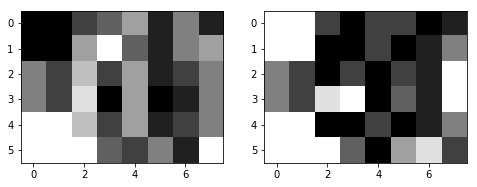

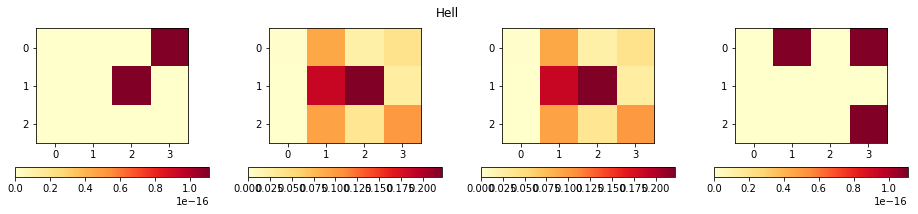

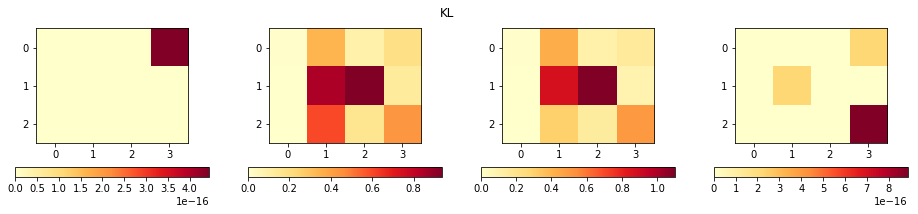

In [4]:
# test matrices
test1 = np.array([[10, 10, 30, 40, 60, 20, 50, 20],
                  [10, 10, 60, 90, 40, 20, 50, 60],
                  [50, 30, 70, 30, 60, 20, 30, 50],
                  [50, 30, 80, 10, 60, 10, 20, 50],
                  [90, 90, 70, 30, 60, 20, 30, 50],
                  [90, 90, 90, 40, 30, 50, 20, 90]])

test2 = np.array([[90, 90, 30, 10, 30, 30, 10, 20],
                  [90, 90, 10, 10, 30, 10, 20, 50],
                  [50, 30, 10, 30, 10, 30, 20, 90],
                  [50, 30, 80, 90, 10, 40, 20, 90],
                  [90, 90, 10, 10, 30, 10, 20, 50],
                  [90, 90, 90, 40, 10, 60, 80, 30]])

f, axarr = plt.subplots(1, 2, figsize=(8, 3))
axarr[0].imshow(test1, cmap="gray")
axarr[1].imshow(test2, cmap="gray")

for metric in ["Hell", "KL"]:
    f, axarr = plt.subplots(1, 4, figsize=(16, 3)) # heatmap
    f.suptitle(metric)
    y = 0
    for (A, B) in [(test1, test1), (test1, test2), (test2, test1), (test2, test2)]:
        a = "test1" if np.array_equal(A, test1) else "test2"
        b = "test1" if np.array_equal(B, test1) else "test2"
        print("Comparing", a, "and", b)
        print("Metric:", metric)
        dist = computeDistance(A, B, 2, metric)
        print(np.around(dist, decimals=2))
        print("dist:", round(np.sum(dist), 2))
        print()
        a = axarr[y].imshow(dist, cmap="YlOrRd")
        f.colorbar(a, ax=axarr[y], orientation='horizontal')
        y += 1
    print("-----------------------")

# Comparing Images

Here we perform comparisons with different images for different purposes.

## Comparing Letters

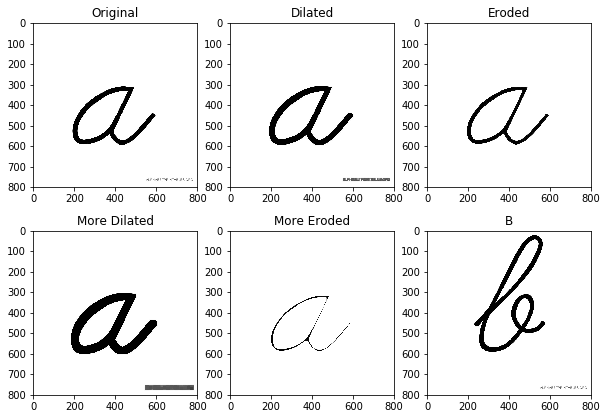

In [5]:
def getTransforms(image):
    '''get transformed versions of image'''
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(image, kernel, iterations = 1)
    erosion = cv2.erode(image, kernel, iterations = 1)
    kernel2 = np.ones((15, 15), np.uint8)
    dilation2 = cv2.dilate(image, kernel2, iterations = 1)
    erosion2 = cv2.erode(image, kernel2, iterations = 1)
    return [dilation, erosion, dilation2, erosion2]

# images for comparisons
base_chars = ["a", "b"]
base_images = [cv2.imread("samples/alphabet_cursive_letter_" + char + ".jpg", 0) for char in base_chars]
base_images = [255 - base_image for base_image in base_images] # invert the image
compare = [base_images[0]] + getTransforms(base_images[0]) + [base_images[1]]
titles = ["Original", "Dilated", "Eroded", "More Dilated", "More Eroded", "B"]

# plot images
f, axarr = plt.subplots(2, 3, figsize=(10, 7))
for i in range(len(compare)):
    axarr[i // 3, i % 3].imshow(compare[i], cmap="Greys")
    axarr[i // 3, i % 3].set_title(titles[i])

Here, we compare the letter A and the letter B against tranformed versions of the letter A. Our block size is `n=15`.

Comparing with Original using Hell


/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  
/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars
/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2022: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric

Distance: 1.1102230246251565e-14 (12.91s)

Comparing with Dilated using Hell
Distance: 37.535617265142584 (15.05s)

Comparing with Eroded using Hell
Distance: 31.864762718949198 (18.82s)

Comparing with More Dilated using Hell
Distance: 83.72041120881129 (15.96s)

Comparing with More Eroded using Hell
Distance: 57.51629997522744 (15.68s)

Comparing with B using Hell
Distance: 65.10518261339199 (14.11s)

Hell & 0.0 & 37.54 & 31.86 & 83.72 & 57.52 & 65.11 & 
------------------------------
Comparing with Original using KL
Distance: 1.9984014443252818e-14 (14.18s)

Comparing with Dilated using KL
Distance: 268.210138996591 (13.7s)

Comparing with Eroded using KL
Distance: 113.77994000128322 (12.19s)

Comparing with More Dilated using KL
Distance: 2584.994943468704 (14.06s)

Comparing with More Eroded using KL
Distance: 241.87011477899924 (13.83s)

Comparing with B using KL
Distance: 2786.8702942107684 (20.27s)

KL & 0.0 & 268.21 & 113.78 & 2584.99 & 241.87 & 2786.87 & 
--------------------

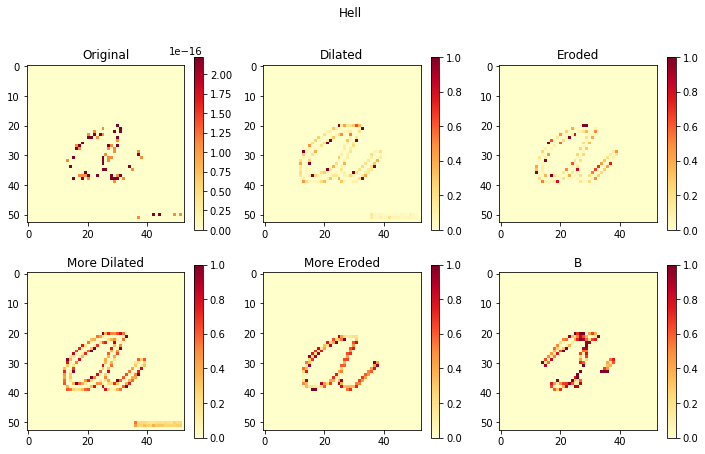

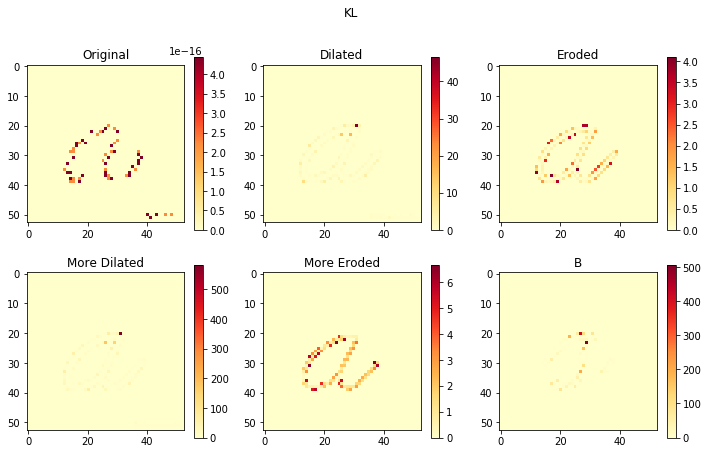

In [6]:
overall_start_time = time.time()
for metric in ["Hell", "KL"]:
    f, axarr = plt.subplots(2, (len(compare) + 1) // 2, figsize=(12, 7))
    f.suptitle(metric)
    debug_print = ""
    
    for i in range(len(compare)):
            print("Comparing with", titles[i], "using", metric)
            start_time = time.time()
            # dist = np.zeros((2,2))
            dist = computeDistance(compare[i], compare[0], 15, metric)
            diff_time = round(time.time() - start_time, 2)
            print("Distance:", np.sum(dist), "(" + str(diff_time) + "s)")
            debug_print += str(round(np.sum(dist), 2)) + " & "
            print()
            a = axarr[i // 3, i % 3].imshow(dist, cmap="YlOrRd")
            axarr[i // 3, i % 3].set_title(titles[i])
            f.colorbar(a, ax=axarr[i // 3, i % 3])
    print(metric, "&", debug_print)
    print("-"*30)
    
overall_diff_time = time.time() - overall_start_time
print("Total running time:", str(overall_diff_time // 60) + "min", str(round(overall_diff_time % 60, 2)) + "s")

## Comparing Compressed Images

Here, we compare an image of a dog with several compressed versions of itself. We use a block size of `n=15`.

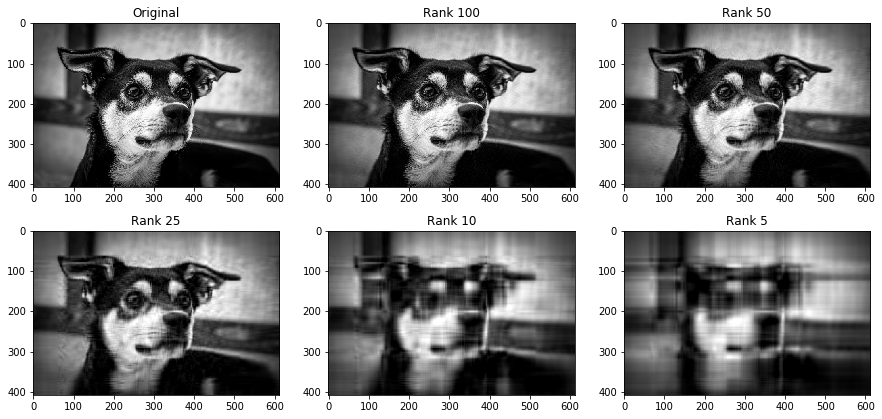

In [7]:
# images for comparisons
original = cv2.imread("samples/original.png", 0)
singular_values = [100, 50, 25, 10, 5]
compressed = [cv2.imread("samples/svd_" + str(svd_val) + ".png", 0) for svd_val in singular_values]

# plot images
f, axarr = plt.subplots(2, 3, figsize=(15, 7))
all_dogs = [original] + compressed
dog_titles = ["Original"] + ["Rank " + str(svd) for svd in singular_values]
for i in range(len(all_dogs)):
    axarr[i // 3, i % 3].imshow(all_dogs[i], cmap="gray")
    axarr[i // 3, i % 3].set_title(dog_titles[i])
    
def dog_compare(n):
    overall_start_time = time.time()

    for metric in ["Hell", "KL"]:
        f, axarr = plt.subplots(1, len(compressed), figsize=(17, 3.5))
        f.suptitle(metric)
        debug_print = ""

        for i in range(len(compressed)):
            print("Comparing with", dog_titles[i], "using", metric)
            start_time = time.time()
            # dist = np.zeros((2,2))
            dist = computeDistance(compressed[i], original, n, metric)
            diff_time = round(time.time() - start_time, 2)
            print("Distance:", np.sum(dist), "(" + str(diff_time) + "s)")
            debug_print += str(round(np.sum(dist), 2)) + " & "
            print()
            a = axarr[i].imshow(dist, cmap="YlOrRd")
            axarr[i].set_title(dog_titles[i])
            f.colorbar(a, ax=axarr[i], orientation='horizontal')
        print(metric, "&", debug_print)
        print("-"*30)

    overall_diff_time = time.time() - overall_start_time
    print("Total running time:", str(overall_diff_time // 60) + "min", str(round(overall_diff_time % 60, 2)) + "s")


Comparing with Original using Hell


/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  
/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2022: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6

Distance: 18.085822727368566 (12.76s)

Comparing with Rank 100 using Hell
Distance: 17.596173968166088 (11.74s)

Comparing with Rank 50 using Hell
Distance: 25.32751693420247 (13.47s)

Comparing with Rank 25 using Hell
Distance: 35.24705123504623 (13.24s)

Comparing with Rank 10 using Hell
Distance: 49.37193095254972 (9.91s)

Hell & 18.09 & 17.6 & 25.33 & 35.25 & 49.37 & 
------------------------------
Comparing with Original using KL
Distance: 1370.6462599278402 (10.66s)

Comparing with Rank 100 using KL
Distance: 1312.0050517625116 (14.11s)

Comparing with Rank 50 using KL
Distance: 1432.9304339268206 (15.9s)

Comparing with Rank 25 using KL
Distance: 1265.5619402120149 (12.96s)

Comparing with Rank 10 using KL
Distance: 1792.2390328919803 (9.97s)

KL & 1370.65 & 1312.01 & 1432.93 & 1265.56 & 1792.24 & 
------------------------------
Total running time: 2.0min 6.28s


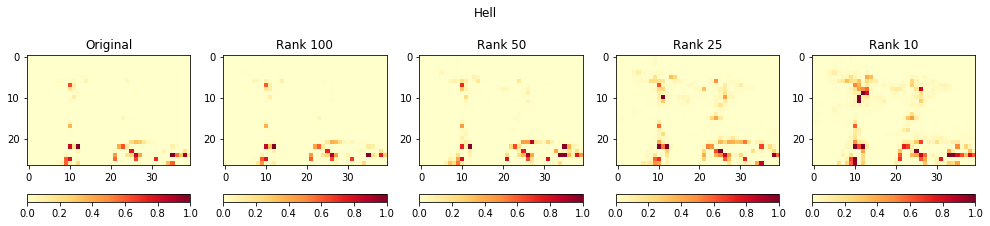

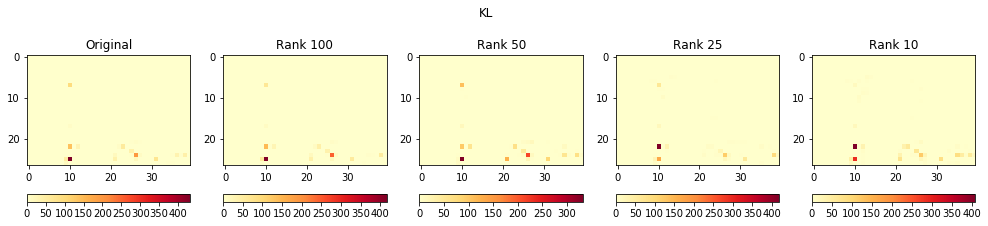

In [8]:
dog_compare(15)

We then try a block size of `n=30`.

Comparing with Original using Hell


/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


Distance: 4.214485761862299 (14.76s)

Comparing with Rank 100 using Hell
Distance: 5.231802903954231 (15.73s)

Comparing with Rank 50 using Hell
Distance: 5.546354707308298 (9.8s)

Comparing with Rank 25 using Hell
Distance: 7.857925969198627 (9.04s)

Comparing with Rank 10 using Hell
Distance: 13.438688009449486 (9.12s)

Hell & 4.21 & 5.23 & 5.55 & 7.86 & 13.44 & 
------------------------------
Comparing with Original using KL
Distance: 606.5795641231811 (9.26s)

Comparing with Rank 100 using KL
Distance: 1196.565001241339 (9.24s)

Comparing with Rank 50 using KL
Distance: 1306.5749099390814 (9.1s)

Comparing with Rank 25 using KL
Distance: 294.0186068945664 (10.76s)

Comparing with Rank 10 using KL
Distance: 1512.1968091251692 (10.48s)

KL & 606.58 & 1196.57 & 1306.57 & 294.02 & 1512.2 & 
------------------------------
Total running time: 1.0min 48.91s


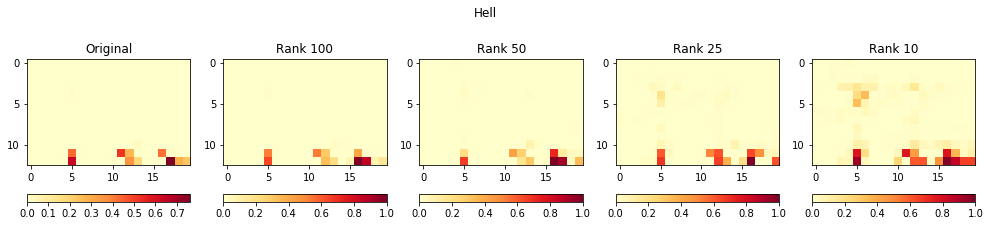

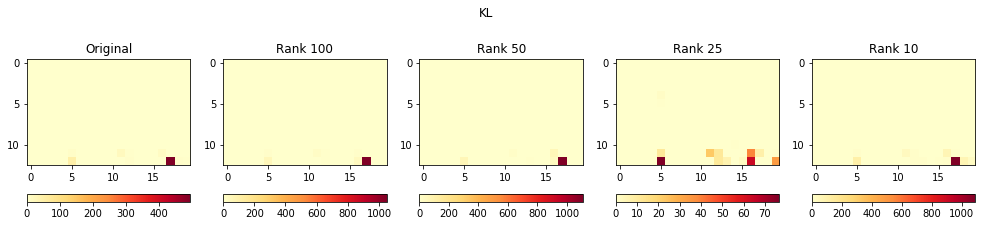

In [9]:
dog_compare(30)

We then try a block size of `n=50`.

Comparing with Original using Hell


/Users/Jacky/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


Distance: 0.5889686913140553 (11.76s)

Comparing with Rank 100 using Hell
Distance: 0.6310407729669368 (11.11s)

Comparing with Rank 50 using Hell
Distance: 0.8116111039271151 (11.05s)

Comparing with Rank 25 using Hell
Distance: 2.3155249846889787 (9.93s)

Comparing with Rank 10 using Hell
Distance: 3.6317533704668072 (9.89s)

Hell & 0.59 & 0.63 & 0.81 & 2.32 & 3.63 & 
------------------------------
Comparing with Original using KL
Distance: 5.754450015447139 (14.73s)

Comparing with Rank 100 using KL
Distance: 5.481812362154481 (13.54s)

Comparing with Rank 50 using KL
Distance: 6.000044943862644 (9.51s)

Comparing with Rank 25 using KL
Distance: 28.935623899205197 (14.85s)

Comparing with Rank 10 using KL
Distance: 45.8948163715329 (11.49s)

KL & 5.75 & 5.48 & 6.0 & 28.94 & 45.89 & 
------------------------------
Total running time: 1.0min 58.96s


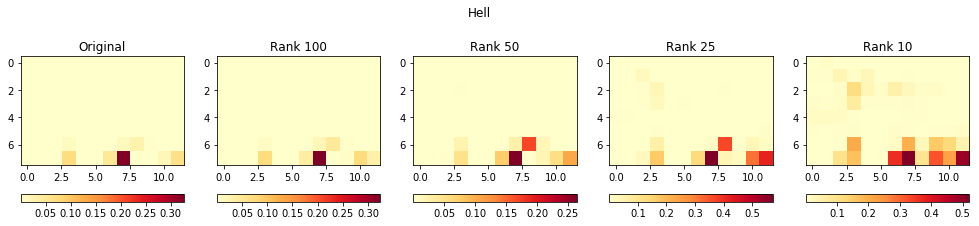

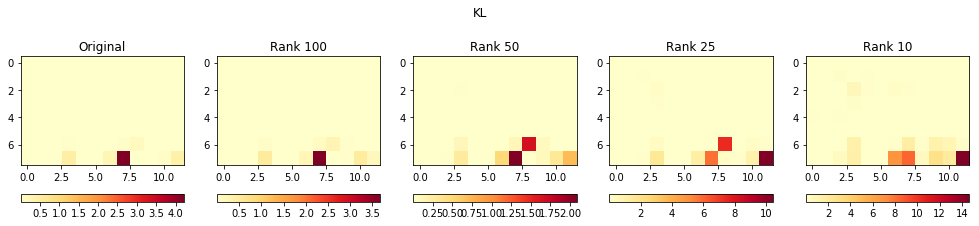

In [10]:
dog_compare(50)